In [27]:
# from google.colab import drive
import os
# drive.mount('/content/gdrive/')
%cd drive/MyDrive/Deep-SEES
!nvidia-smi

[Errno 2] No such file or directory: 'drive/MyDrive/Deep-SEES'
/content/drive/MyDrive/Deep-SEES
Mon Sep 19 04:44:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |    970MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------

In [28]:
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch
import pandas as pd
import plotly
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection  import train_test_split
import lstm_vae.utils as myutils
from lstm_vae.VraeAnalyzer import VraeAnalyzer
plotly.offline.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [29]:
dload = './model_dir' #download directory
is_train = 0
###data loader
path = './data/'
filename_set = ['lorentz_sigma_2.5'] #ecg, kolmogorov roessler, roessler, fbm_mT_full_iso
model_name = 'vrae_' + ''.join([i for i in filename_set[0]])\
              +'.pth'

In [30]:
#%% Hyper parameters

hidden_size = 128#128 #90
hidden_layer_depth = 2
latent_length = 32#32 #20
batch_size = 50 #
learning_rate = 0.0005#0.0005
n_epochs = 40 # 40
dropout_rate = 0.2 #0.2
n_scale = 3 
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=500
clip = True # options: True, False
max_grad_norm=5 # 5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

In [31]:
#%%  VraeAnalyzer Hyperparamters
num_features=3
is_range = False # if every dimension is dependent use this item
n_cluster=9
#%%
seq_len=30
brownian_filter=(0,0) #(delta, model_error)
alpha_ROI_select=(-np.inf,np.inf)#(0,0.5)#(-np.inf,np.inf)
# Reconstruct_error_select=(0,1) #(0,1)
Reconstruct_error_select=(0,1) #(0,1)
seed = 0
 # if every dimension is dependent use this item
 

In [32]:
df,_,_= myutils.load_data(path,filename_set)


data,_ = myutils.data_processing(df,num_features,seq_len)
# scalar = max(3 / np.mean(np.mean(np.abs(data))),1)
if is_range:
    scalar = n_scale/np.mean(np.mean(np.abs(data),axis=0),axis=0)
else:
    s = n_scale / np.mean(np.mean(np.abs(data)))
    scalar = [s for i in range(num_features)]
data = data * scalar
label = df.iloc[:, -1].values
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.20, random_state=0)


num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
y_val -= base
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_val))
sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size,
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer,
            cuda = cuda,
            print_every=print_every,
            clip=clip,
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)
if is_train:
    vrae.fit(train_dataset)
    vrae.evaluate(test_dataset)

    vrae.save(model_name)

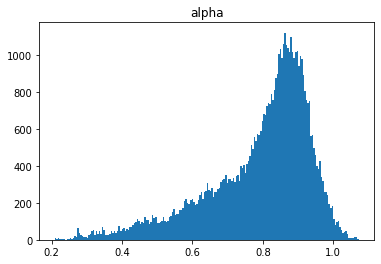

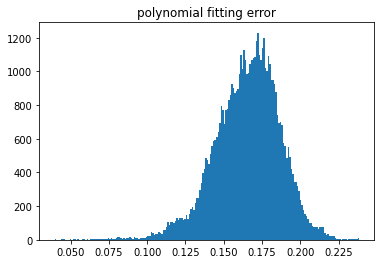

In [33]:
#%% VraeAnalyze load
vrae.load(dload + '/'+model_name)
Analyzer = VraeAnalyzer(vrae,path,filename_set,num_features=num_features,seq_len=seq_len,n_cluster=n_cluster,
             brownian_filter=brownian_filter,alpha_ROI_select=alpha_ROI_select,Reconstruct_error_select=Reconstruct_error_select,
             seed = seed, is_range = is_range, n_scale = n_scale)

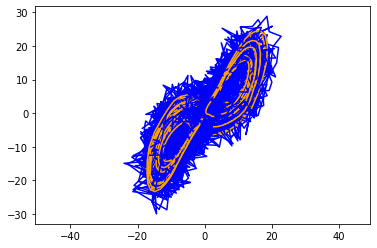

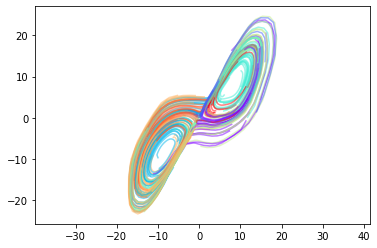

normalized


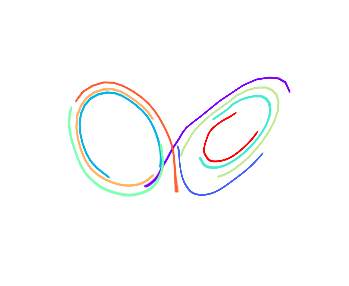

In [34]:
Analyzer.plot_filtering_traj(num=200,is_filtering=False,scalar = scalar) # seed = 2 of 15min-1, num=250, 
Analyzer.plot_clustering_traj(num=200,scalar = scalar) #num=400 scalar = scalar
# Analyzer.plot_filtering_traj_overlay(lo=0,step=15000)
Analyzer.run_centers(scalar = scalar)

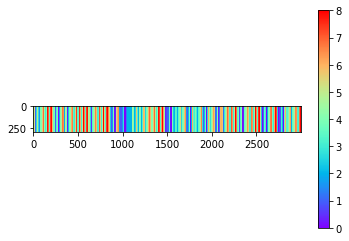

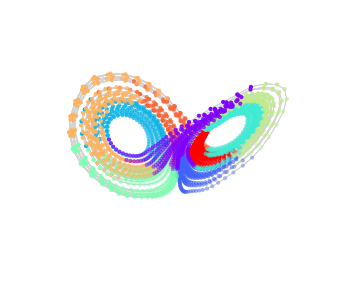

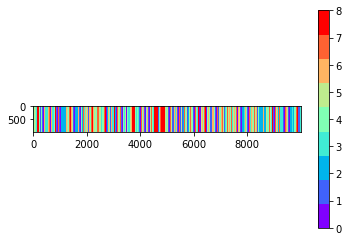

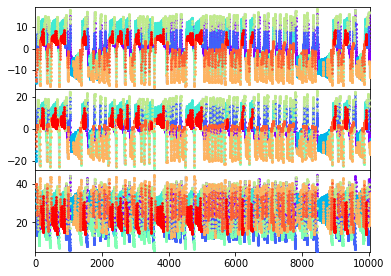

In [35]:
Analyzer.plot_every_trajectory(is_filtering=True)
Analyzer.plot_every_time_series(lo=0,step=10000,extend=0.05,sz=0.05) #0.05, 0.05

In [36]:

# Analyzer.re_clustering(id_k=3,num_clustering=13)
# Analyzer.run_centers(scalar = scalar)
# Analyzer.plot_every_time_series(lo=12000,step=3000,extend=0.05,sz=0.05) #0.05, 0.05